In [ ]:
!pip install torch_geometric
import time
import tensorflow as tf
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.6 MB/s eta 0:00:00


In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
## determine the dataset: cora, citeseer, and pubmed
dataset = Planetoid(root='data/Cora', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.
print(data)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Processing...
Done!


In [ ]:
dataset = Planetoid(root=data_dir, name='Cora')
data = dataset[0]
print(f'Number of nodes: {data.num_nodes}') # Number of nodes: based on the dataset you choose
print(f'Number of edges: {data.num_edges}') # Number of edges: based on the dataset

Processing...


Number of nodes: 2708
Number of edges: 10556


Done!


In [ ]:
print(f'Number of features: {data.num_node_features}') # Number of edge features: 0
print(len(data.x[0])) #display some of the features, and you can
#see that they are composed of 0s and 1s
data.x[0][:20]
print(f'Number of edge features: {data.num_edge_features}') # Number of edge features: 0
print(f'Number of classes: {dataset.num_classes}') # Number of classes: 7

Number of features: 1433
1433
Number of edge features: 0
Number of classes: 7


In [ ]:
#the details for our dataset
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}
data.y[:10]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])

{3: 818, 4: 426, 0: 351, 2: 418, 1: 217, 5: 298, 6: 180}


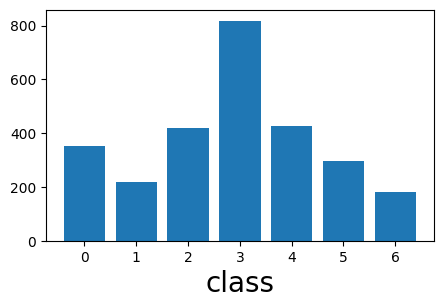

In [ ]:
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(5, 3))
plt.bar(range(7), count) # for Cora is 7 and Citeseer is 6, Pubmed=3
plt.xlabel("class", size=20)
plt.show()

label: 0
532 edges
{2: 46, 4: 93, 1: 111, 0: 194, 5: 21, 3: 67}
label: 1
1420 edges
{1: 904, 3: 60, 0: 111, 5: 28, 2: 238, 4: 79}
label: 2
2657 edges
{0: 46, 2: 2082, 3: 180, 4: 47, 1: 238, 5: 64}
label: 3
1647 edges
{3: 1256, 4: 50, 2: 180, 1: 60, 0: 67, 5: 34}
label: 4
1733 edges
{3: 50, 4: 1378, 5: 86, 1: 79, 0: 93, 2: 47}
label: 5
1115 edges
{5: 882, 4: 86, 0: 21, 2: 64, 1: 28, 3: 34}


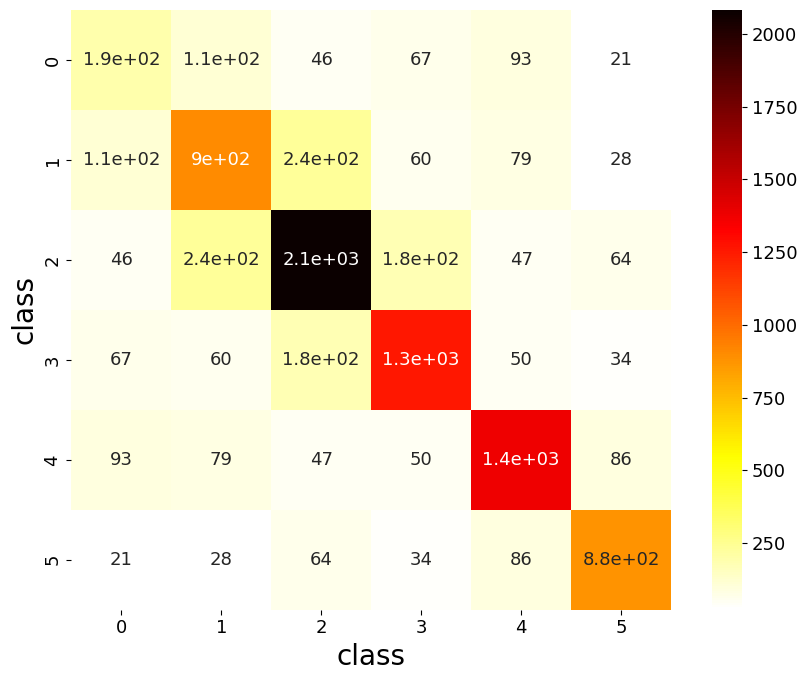

In [ ]:
##Data preprocessing
#For the seven classes we looked at earlier, we will see how many nodes of the same
#class are connected by edges and vice versa. This property is called homophily.
labels = data.y.numpy()
connected_labels_set = list(map(lambda x: labels[x], data.edge_index.numpy()))
connected_labels_set = np.array(connected_labels_set)
def add_missing_keys(counter, classes):
    for x in classes:
        if x not in counter.keys():
            counter[x] = 0
    return counter
label_connection_counts = []
for i in range(6): #7,6,3
    print(f"label: {i}")
    connected_labels = connected_labels_set[:, np.where(connected_labels_set[0] == i)[0]]
    print(connected_labels.shape[1], "edges")
    counter = collections.Counter(connected_labels[1])
    counter = dict(counter)
    print(counter)
    counter = add_missing_keys(counter, range(6)) # CORA =7, Citeseer=6, PubMed=3
    items = sorted(counter.items())
    items = [x[1] for x in items]
    label_connection_counts.append(items)
label_connection_counts = np.array(label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(label_connection_counts, annot=True, cmap='hot_r', cbar=True, square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

In [ ]:
# we calculate the percentage of edges connected within the same class.
label_connection_counts.diagonal().sum() / label_connection_counts.sum()

0.7355008787346221

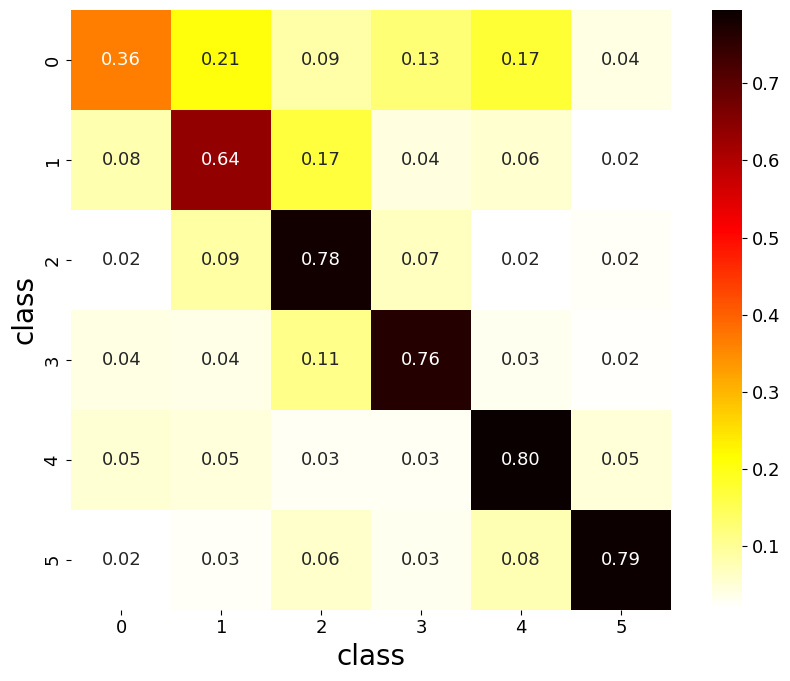

In [ ]:
#Determine the edges that are connected within the same class.
def scaling(array):
    return array / sum(array)
label_connection_counts_scaled = np.apply_along_axis(scaling, 1, label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(
    label_connection_counts_scaled,
    annot=True,
    cmap='hot_r',
    fmt="1.2f",
    cbar=True,
    square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

In [ ]:
#the details for our dataset
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}
data.y[:10]

tensor([3, 1, 5, 5, 3, 1, 3, 0, 3, 5])

In [ ]:
from collections import Counter
import numpy as np
# Assuming 'labels' is a list of class labels for the nodes in the Cora dataset
# Example: labels = [0, 1, 0, 1, 2, 2, 0, ...]

# Count the frequency of each class
class_counts = Counter(data)

# Find the number of instances in the minority class
min_count = min(class_counts.values())

# Calculate the imbalance ratio for each class
imbalance_ratios = {class_label: count / min_count for class_label, count in class_counts.items()}

# Print the imbalance ratio for each class
for class_label, ratio in imbalance_ratios.items():
  print(f"Class {class_label} Imbalance Ratio: {ratio:.2f}")

Class ('x', tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])) Imbalance Ratio: 1.00
Class ('edge_index', tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])) Imbalance Ratio: 1.00
Class ('y', tensor([3, 4, 4,  ..., 3, 3, 3])) Imbalance Ratio: 1.00
Class ('train_mask', tensor([ True,  True,  True,  ..., False, False, False])) Imbalance Ratio: 1.00
Class ('val_mask', tensor([False, False, False,  ..., False, False, False])) Imbalance Ratio: 1.00
Class ('test_mask', tensor([False, False, False,  ...,  True,  True,  True])) Imbalance Ratio: 1.00


Processing...
Done!


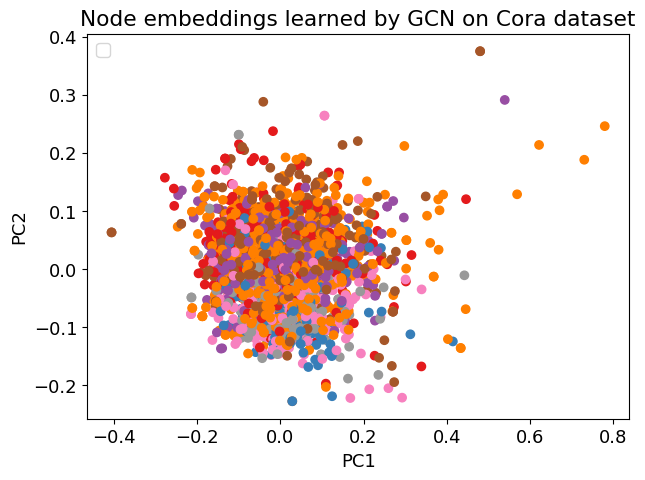

In [ ]:
#!pip install sklearn
import torch
import torch.nn as nn
import torch_geometric as tg
import sklearn
from sklearn import decomposition
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch.nn import ReLU, Dropout
import torch.nn.functional as F

#Load the dataset
dataset = tg.datasets.Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

#Define the GCN model
class GCN(nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels):
    super(GCN, self).__init__()
    torch.manual_seed(42)
    self.conv1 = GCNConv(in_channels, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, out_channels)

  def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


#Create an instance of the GCN model
in_channels = dataset.num_node_features
out_channels = dataset.num_classes

model = GCN(hidden_channels=16, in_channels=in_channels, out_channels=out_channels)

#Train the model

model.train()
for epoch in range(10):
  pass

#Get the node embeddings from the model
model.eval()
out = model(data.x, data.edge_index)
embeddings = out.detach().numpy()

#Apply PCA to reduce the dimensionality of the embeddings
pca = sklearn.decomposition.PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

#Plot the node embeddings using scatter plot
plt.figure(figsize=(7,5))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c=data.y, cmap="Set1")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Node embeddings learned by GCN on Cora dataset")
plt.legend(loc='upper left')
plt.show()

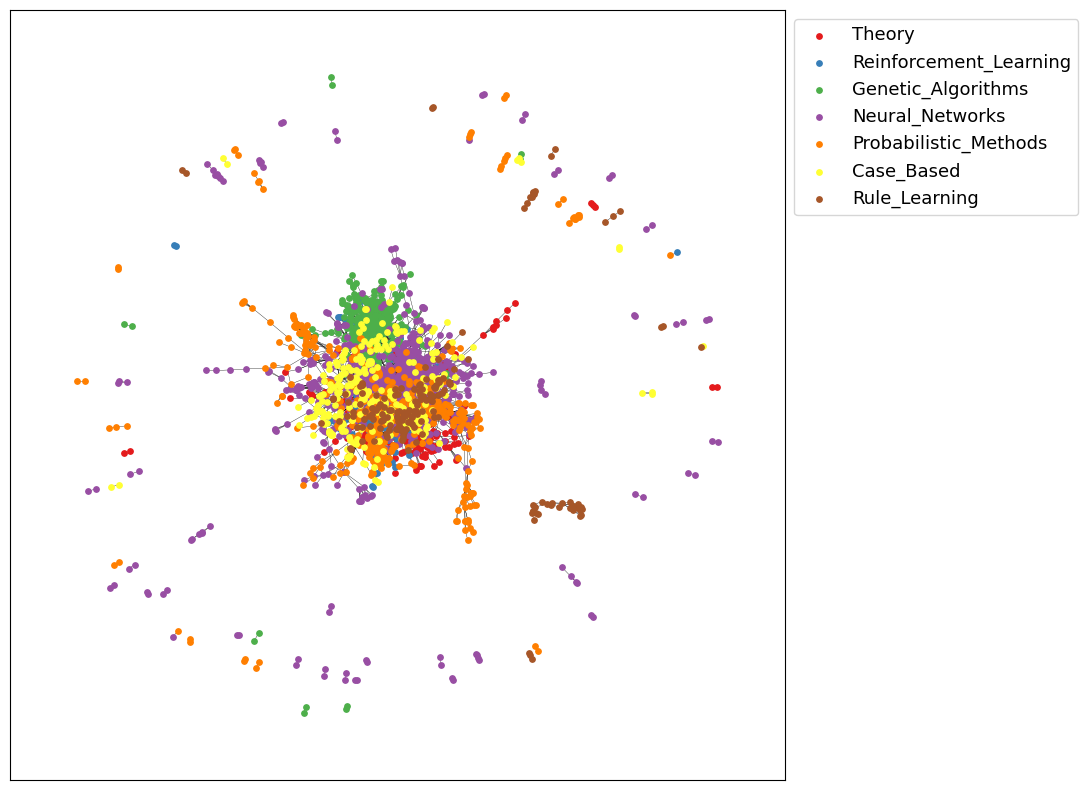

In [ ]:
#draw a network diagram to see if the classes are distributed coherently
G = to_networkx(data, to_undirected=True)
node_color = []
nodelist = [[], [], [], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 10))
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 15, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from torch_geometric.datasets import Planetoid
from sklearn.metrics import accuracy_score
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

class ETSA(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, num_gcn_layers=1, attention_type='sigmoid', dropout_rate=0.5):
        super(ETSA, self).__init__()

        self.embedding_layer = nn.Linear(num_features, hidden_dim)
        self.num_gcn_layers = num_gcn_layers
        self.gcn_layers = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(num_gcn_layers)])

        # Experiment with attention mechanisms
        if attention_type == 'sigmoid':
            self.stage_1_attention = nn.Linear(hidden_dim, 1)
            self.stage_2_attention = nn.Linear(hidden_dim, 1)
        elif attention_type == 'softmax':
            self.stage_1_attention = nn.Linear(hidden_dim, hidden_dim)
            self.stage_2_attention = nn.Linear(hidden_dim, hidden_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(p=dropout_rate)

        self.final_gcn_layer = GCNConv(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        # Embedding Layer
        x = self.embedding_layer(x)

        # GCN Layers with dropout
        for i in range(self.num_gcn_layers):
            x = F.relu(self.gcn_layers[i](x, edge_index))
            x = self.dropout(x)

        # Stage 1 Attention
        stage_1_attention_weights = torch.sigmoid(self.stage_1_attention(x))
        stage_1_representation = torch.sum(x * stage_1_attention_weights, dim=0)

        # Stage 2 Attention
        stage_2_attention_weights = torch.sigmoid(self.stage_2_attention(x))
        stage_2_representation = torch.sum(x * stage_2_attention_weights, dim=0)

        # Combine Satge 1 and Stage 2 Representations
        combined_representation = stage_1_representation + stage_2_representation

        # Final GCN Layer
        x = self.final_gcn_layer(x, edge_index)

        return x, combined_representation

# Load CORA dataset
cora_dataset = Planetoid(root='data/PubMed', name='PubMed')

# Set random seed for reproducibility
torch.manual_seed(42)

# Instantiate the ETSA model
model = ETSA(num_features=cora_dataset.num_features, hidden_dim=64, num_classes=cora_dataset.num_classes, num_gcn_layers=2, attention_type='sigmoid', dropout_rate=0.5)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

# Early stopping
best_val_accuracy = 0.0
patience = 10
counter = 0

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Use DataLoader for mini-batch training
    for data in DataLoader(cora_dataset, batch_size=1, shuffle=True):
        out, _ = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_mask = cora_dataset.val_mask
        val_logits, _ = model(cora_dataset.x, cora_dataset.edge_index)
        val_pred_labels = val_logits.argmax(dim=1)[val_mask]
        val_accuracy = accuracy_score(cora_dataset.y[val_mask], val_pred_labels)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Learning rate scheduler step
    scheduler.step(val_accuracy)

    # Early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping. No improvement in validation accuracy.")
            break

#%%


Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/100, Loss: 1.7917, Validation Accuracy: 0.4620


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 2/100, Loss: 1.6522, Validation Accuracy: 0.6780


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 3/100, Loss: 1.4050, Validation Accuracy: 0.7780


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 4/100, Loss: 1.0917, Validation Accuracy: 0.7980


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 5/100, Loss: 0.9090, Validation Accuracy: 0.8120


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 6/100, Loss: 0.7771, Validation Accuracy: 0.8280


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 7/100, Loss: 0.6853, Validation Accuracy: 0.8360


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 8/100, Loss: 0.6688, Validation Accuracy: 0.8440


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 9/100, Loss: 0.6280, Validation Accuracy: 0.8500


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 10/100, Loss: 0.5820, Validation Accuracy: 0.8480


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 11/100, Loss: 0.5552, Validation Accuracy: 0.8560


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 12/100, Loss: 0.5357, Validation Accuracy: 0.8560


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 13/100, Loss: 0.4888, Validation Accuracy: 0.8660


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 14/100, Loss: 0.4761, Validation Accuracy: 0.8580


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 15/100, Loss: 0.4687, Validation Accuracy: 0.8660


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 16/100, Loss: 0.4649, Validation Accuracy: 0.8600


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 17/100, Loss: 0.4366, Validation Accuracy: 0.8660


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 18/100, Loss: 0.4348, Validation Accuracy: 0.8740


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 19/100, Loss: 0.4186, Validation Accuracy: 0.8800


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 20/100, Loss: 0.4071, Validation Accuracy: 0.8880


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 21/100, Loss: 0.4057, Validation Accuracy: 0.8880


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 22/100, Loss: 0.3946, Validation Accuracy: 0.8900


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 23/100, Loss: 0.3830, Validation Accuracy: 0.8980


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 24/100, Loss: 0.3749, Validation Accuracy: 0.8900


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 25/100, Loss: 0.3671, Validation Accuracy: 0.8820


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 26/100, Loss: 0.3569, Validation Accuracy: 0.8900


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 27/100, Loss: 0.3454, Validation Accuracy: 0.8900


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 28/100, Loss: 0.3516, Validation Accuracy: 0.8880


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 29/100, Loss: 0.3465, Validation Accuracy: 0.8860


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 30/100, Loss: 0.3433, Validation Accuracy: 0.8860


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 31/100, Loss: 0.3380, Validation Accuracy: 0.8840


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 32/100, Loss: 0.3299, Validation Accuracy: 0.8860


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 33/100, Loss: 0.3327, Validation Accuracy: 0.8840
Early stopping. No improvement in validation accuracy.


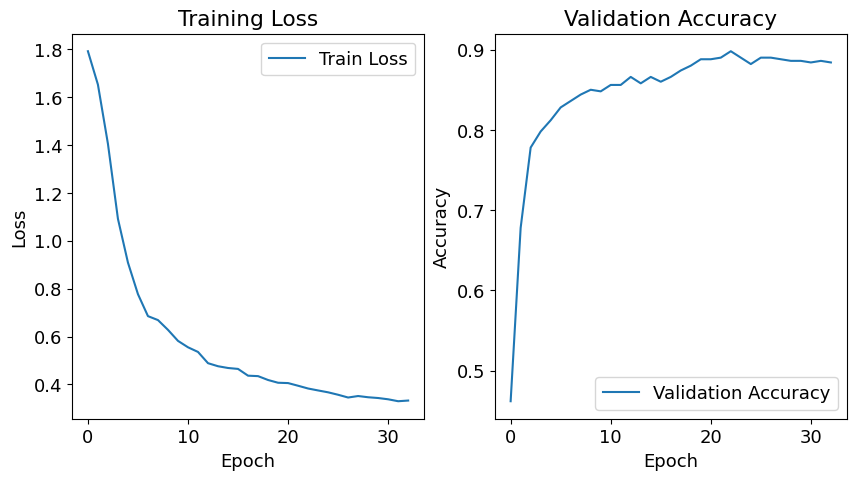

Test AUC: 0.9910
Test F1-score (Macro): 0.8663


NameError: name 'roc_curve' is not defined

In [ ]:


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from torch_geometric.datasets import Planetoid
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

class ETSA(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, num_gcn_layers=1, attention_type='sigmoid', dropout_rate=0.5):
        super(ETSA, self).__init__()

        self.embedding_layer = nn.Linear(num_features, hidden_dim)
        self.num_gcn_layers = num_gcn_layers
        self.gcn_layers = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(num_gcn_layers)])

        # Experiment with attention mechanisms
        if attention_type == 'sigmoid':
            self.stage_1_attention = nn.Linear(hidden_dim, 1)
            self.stage_2_attention = nn.Linear(hidden_dim, 1)
        elif attention_type == 'softmax':
            self.stage_1_attention = nn.Linear(hidden_dim, hidden_dim)
            self.stage_2_attention = nn.Linear(hidden_dim, hidden_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(p=dropout_rate)

        self.final_gcn_layer = GCNConv(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        # Embedding Layer
        x = self.embedding_layer(x)

        # GCN Layers with dropout
        for i in range(self.num_gcn_layers):
            x = F.relu(self.gcn_layers[i](x, edge_index))
            x = self.dropout(x)

        # Stage 1 Attention
        stage_1_attention_weights = torch.sigmoid(self.stage_1_attention(x))
        stage_1_representation = torch.sum(x * stage_1_attention_weights, dim=0)

        # Stage 2 Attention
        stage_2_attention_weights = torch.sigmoid(self.stage_2_attention(x))
        stage_2_representation = torch.sum(x * stage_2_attention_weights, dim=0)

        # Combine Stage 1 and Stage 2 Representations
        combined_representation = stage_1_representation + stage_2_representation

        # Final GCN Layer
        x = self.final_gcn_layer(x, edge_index)

        return x, combined_representation

# Load CORA dataset
cora_dataset = Planetoid(root='data/CiteSeer', name='CiteSeer')

# Set random seed for reproducibility
torch.manual_seed(42)

# Instantiate the ETSA model
model = ETSA(num_features=cora_dataset.num_features, hidden_dim=64, num_classes=cora_dataset.num_classes, num_gcn_layers=2, attention_type='sigmoid', dropout_rate=0.5)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

# Early stopping
best_val_accuracy = 0.0
patience = 10
counter = 0

# Training loop
num_epochs = 100

train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Use DataLoader for mini-batch training
    for data in DataLoader(cora_dataset, batch_size=1, shuffle=True):
        out, _ = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_mask = cora_dataset.val_mask
        val_logits, _ = model(cora_dataset.x, cora_dataset.edge_index)
        val_pred_labels = val_logits.argmax(dim=1)[val_mask]
        val_accuracy = accuracy_score(cora_dataset.y[val_mask], val_pred_labels)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}')

    train_losses.append(loss.item())
    val_accuracies.append(val_accuracy)

    # Learning rate scheduler step
    scheduler.step(val_accuracy)

    # Early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping. No improvement in validation accuracy.")
            break

# Plotting train losses and validation accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()



# Evaluation on test set
model.eval()
with torch.no_grad():
    test_mask = cora_dataset.test_mask
    test_logits, _ = model(cora_dataset.x, cora_dataset.edge_index)
    test_pred_labels = test_logits.argmax(dim=1)[test_mask]
    test_true_labels = cora_dataset.y[test_mask]

    # Calculate AUC and F1-score only for the test set
    test_probs = F.softmax(test_logits[test_mask], dim=1).numpy()
    test_true_labels_onehot = torch.eye(cora_dataset.num_classes)[test_true_labels].numpy()
    auc_score = roc_auc_score(test_true_labels_onehot, test_probs, average='macro', multi_class='ovo')
    f1_score_macro = f1_score(test_true_labels, test_pred_labels, average='macro')

print(f'Test AUC: {auc_score:.4f}')
print(f'Test F1-score (Macro): {f1_score_macro:.4f}')


# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(cora_dataset.num_classes):
    fpr[i], tpr[i], _ = roc_curve((test_true_labels == i).numpy(), test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(cora_dataset.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/15, Loss: 1.7917, Validation Accuracy: 0.4620


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 2/15, Loss: 1.6522, Validation Accuracy: 0.6780


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 3/15, Loss: 1.4050, Validation Accuracy: 0.7780


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 4/15, Loss: 1.0917, Validation Accuracy: 0.7980


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 5/15, Loss: 0.9090, Validation Accuracy: 0.8120


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 6/15, Loss: 0.7771, Validation Accuracy: 0.8280


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 7/15, Loss: 0.6853, Validation Accuracy: 0.8360


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 8/15, Loss: 0.6688, Validation Accuracy: 0.8440


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 9/15, Loss: 0.6280, Validation Accuracy: 0.8500


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 10/15, Loss: 0.5820, Validation Accuracy: 0.8480


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 11/15, Loss: 0.5552, Validation Accuracy: 0.8560


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 12/15, Loss: 0.5357, Validation Accuracy: 0.8560


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 13/15, Loss: 0.4888, Validation Accuracy: 0.8660


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 14/15, Loss: 0.4761, Validation Accuracy: 0.8580


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 15/15, Loss: 0.4687, Validation Accuracy: 0.8660


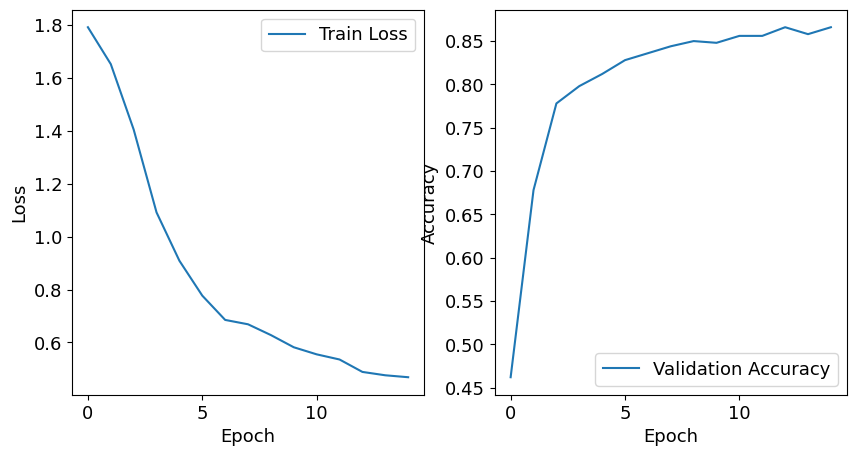

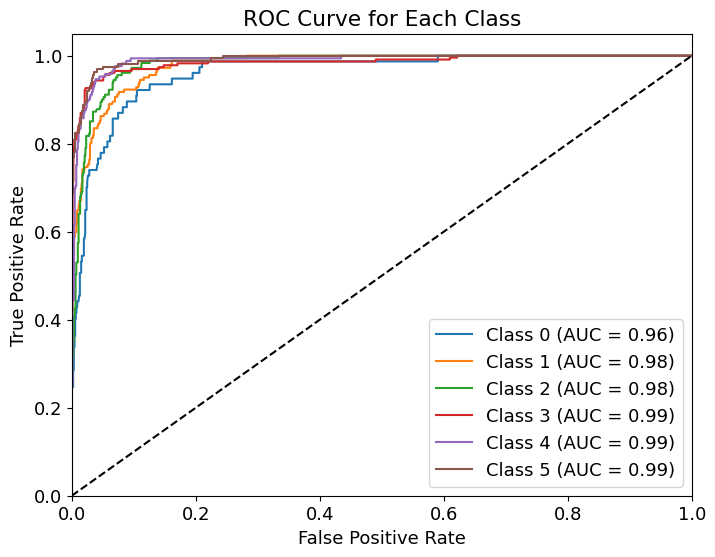

Overall Test AUC: 0.9813


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
from torch_geometric.datasets import Planetoid
from sklearn.metrics import accuracy_score, roc_curve, auc, f1_score
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

from absl import flags
from absl.flags import FLAGS
from enum import Flag
import tensorflow as tf
class ETSA(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, num_gcn_layers=1, attention_type='sigmoid', dropout_rate=0.5):
        super(ETSA, self).__init__()

        self.embedding_layer = nn.Linear(num_features, hidden_dim)
        self.num_gcn_layers = num_gcn_layers
        self.gcn_layers = nn.ModuleList([GCNConv(hidden_dim, hidden_dim) for _ in range(num_gcn_layers)])

        # Experiment with attention mechanisms
        if attention_type == 'sigmoid':
            self.stage_1_attention = nn.Linear(hidden_dim, 1)
            self.stage_2_attention = nn.Linear(hidden_dim, 1)
        elif attention_type == 'softmax':
            self.stage_1_attention = nn.Linear(hidden_dim, hidden_dim)
            self.stage_2_attention = nn.Linear(hidden_dim, hidden_dim)

        # Dropout for regularization
        self.dropout = nn.Dropout(p=dropout_rate)

        self.final_gcn_layer = GCNConv(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        # Embedding Layer
        x = self.embedding_layer(x)

        # GCN Layers with dropout
        for i in range(self.num_gcn_layers):
            x = F.relu(self.gcn_layers[i](x, edge_index))
            x = self.dropout(x)

        # Stage 1 Attention
        stage_1_attention_weights = torch.sigmoid(self.stage_1_attention(x))
        stage_1_representation = torch.sum(x * stage_1_attention_weights, dim=0)

        # Stage 2 Attention
        stage_2_attention_weights = torch.sigmoid(self.stage_2_attention(x))
        stage_2_representation = torch.sum(x * stage_2_attention_weights, dim=0)

        # Combine Stage 1 and Stage 2 Representations
        combined_representation = stage_1_representation + stage_2_representation

        # Final GCN Layer
        x = self.final_gcn_layer(x, edge_index)

        return x, combined_representation

# Load CORA dataset
cora_dataset = Planetoid(root='data/Citeseer', name='Citeseer')

# Set random seed for reproducibility
# torch.manual_seed(42)
# # Settings
# def del_all_flags(FLAGS):
#     flags_dict = FLAGS._flags()
#     keys_list = [keys for keys in flags_dict]
#     for keys in keys_list:
#         FLAGS.__delattr__(keys)

# del_all_flags(tf.compat.v1.flags.FLAGS)

# flags = tf.compat.v1.app.flags
# FLAGS = tf.compat.v1.app.flags.FLAGS
# FLAGS = flags.FLAGS
# tf.compat.v1.flags.DEFINE_string('f','','')
# flags.DEFINE_string('dataset', 'citeseer', 'Dataset string.')  # 'cora', 'citeseer', 'pubmed'
# flags.DEFINE_string('model', 'ETSA', 'Model string.')
# flags.DEFINE_float('learning_rate', 0.001, 'Initial learning rate.')
# flags.DEFINE_integer('epochs', 50, 'Number of epochs to train.')
# flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
# flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')
# flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
# flags.DEFINE_integer('early_stopping', 35, 'Tolerance for early stopping (# of epochs).')
# flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')
# flags.DEFINE_float('imbalance_ratio', 0.6, 'Imbalance Ratio')
# flags.DEFINE_float('lambda', 0, 'parameter sensitivity')
# flags.DEFINE_integer('attention', 8, 'number of attention heads')




#Create an instance of the GCN model
#in_channels = dataset.num_node_features
#out_channels = dataset.num_classes

#model = GCN(hidden_channels=16, in_channels=in_channels, out_channels=out_channels)
# Instantiate the ETSA model
model = ETSA(num_features=cora_dataset.num_features, hidden_dim=64, num_classes=cora_dataset.num_classes,
             num_gcn_layers=2, attention_type='sigmoid', dropout_rate=0.5)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

# Early stopping
best_val_accuracy = 0.0
patience = 10
counter = 0

# Training loop
num_epochs = 15

train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Use DataLoader for mini-batch training
    for data in DataLoader(cora_dataset, batch_size=1, shuffle=True):
        out, _ = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

    # Evaluation on validation set
    model.eval()
    with torch.no_grad():
        val_mask = cora_dataset.val_mask
        val_logits, _ = model(cora_dataset.x, cora_dataset.edge_index)
        val_pred_labels = val_logits.argmax(dim=1)[val_mask]
        val_accuracy = accuracy_score(cora_dataset.y[val_mask], val_pred_labels)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Validation Accuracy: {val_accuracy:.4f}')

    train_losses.append(loss.item())
    val_accuracies.append(val_accuracy)

    # Learning rate scheduler step
    scheduler.step(val_accuracy)

    # Early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping. No improvement in validation accuracy.")
            break

# Plotting train losses and validation accuracies
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('') #Training Loss
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('') #Validation Accuracy
plt.legend()

plt.show()

# Evaluate on test set
model.eval()
with torch.no_grad():
    test_mask = cora_dataset.test_mask
    test_logits, _ = model(cora_dataset.x, cora_dataset.edge_index)
    test_probs = F.softmax(test_logits[test_mask], dim=1).numpy()
    test_true_labels = cora_dataset.y[test_mask]


# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(cora_dataset.num_classes):
    fpr[i], tpr[i], _ = roc_curve((test_true_labels == i).numpy(), test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(cora_dataset.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

# Calculate overall AUC
overall_auc = np.mean(list(roc_auc.values()))
print(f'Overall Test AUC: {overall_auc:.4f}')
#print(f'Test F1-score (Macro): {f1_score_macro:.4f}')
